In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mido import MidiFile, tick2second
from pretty_midi import PrettyMIDI
import pickle
import os
import os.path

### Generating bootleg score

In [3]:
def showImage(X, sz = (6,6)):
    plt.figure(figsize = sz)
    plt.imshow(X, cmap = 'gray', origin = 'lower')

In [4]:
def getNoteEvents(midifile, quant = 10):
    ### Given a midi file, return a list of (t_tick, t_sec, notes) tuples for simultaneous note events
    
    # get note onset info
    mid = MidiFile(midifile)
    noteEvents = []
    for i, track in enumerate(mid.tracks):
        t = 0 
        for msg in track:
            t += msg.time # ticks since last event
            if msg.type == 'note_on' and msg.velocity > 0:
                noteEvents.append((t, msg.note))
    noteEvents = sorted(noteEvents) # merge note events from all tracks, sort by time
    noteTimes = PrettyMIDI(midifile).get_onsets() # in sec
    noteOnsets = [(t_ticks, t_sec, note) for ((t_ticks, note), t_sec) in zip(noteEvents, noteTimes)]
    
    # collapse simultaneous notes
    d = {}
    ticks_quant = [n[0]//quant for n in noteOnsets] # quantized time units (ticks)
    for n, t_quant in zip(noteOnsets, ticks_quant):
        if t_quant not in d:
            d[t_quant] = {}
            d[t_quant]['ticks'] = []
            d[t_quant]['secs'] = []
            d[t_quant]['notes'] = []
        d[t_quant]['ticks'].append(n[0])
        d[t_quant]['secs'].append(n[1])
        d[t_quant]['notes'].append(n[2])
        
    result = [(d[key]['ticks'][0], d[key]['secs'][0], d[key]['notes']) for key in sorted(d.keys())]
    
    return result, d # return d for debugging

In [5]:
def generateBootlegScore(noteEvents, repeatNotes = 1, filler = 1):
    rh_dim = 34 # E3 to C8 (inclusive)
    lh_dim = 28 # A1 to G4 (inclusive)
    rh = [] # list of arrays of size rh_dim
    lh = [] # list of arrays of size lh_dim
    numNotes = [] # number of simultaneous notes
    times = [] # list of (tsec, ttick) tuples indicating the time in ticks and seconds
    mapR, mapL = getNoteheadPlacementMapping() # maps midi numbers to locations on right and left hand staves
    for i, (ttick, tsec, notes) in enumerate(noteEvents):
        
        # insert empty filler columns between note events
        if i > 0:
            for j in range(filler):
                rh.append(np.zeros((rh_dim,1)))
                lh.append(np.zeros((lh_dim,1)))
                numNotes.append(0)
            # get corresponding times using linear interpolation
            interp_ticks = np.interp(np.arange(1, filler+1), [0, filler+1], [noteEvents[i-1][0], ttick])
            interp_secs = np.interp(np.arange(1, filler+1), [0, filler+1], [noteEvents[i-1][1], tsec])
            for tup in zip(interp_secs, interp_ticks):
                times.append((tup[0], tup[1]))

        # insert note events columns
        rhvec = np.zeros((rh_dim, 1))
        lhvec = np.zeros((lh_dim, 1))
        for midinum in notes:
            rhvec += getNoteheadPlacement(midinum, mapR, rh_dim)
            lhvec += getNoteheadPlacement(midinum, mapL, lh_dim)
        for j in range(repeatNotes):
            rh.append(rhvec)
            lh.append(lhvec)
            numNotes.append(len(notes))
            times.append((tsec, ttick))
    rh = np.clip(np.squeeze(np.array(rh)).T, 0, 1) # clip in case e.g. E and F played simultaneously
    lh = np.clip(np.squeeze(np.array(lh)).T, 0, 1) 
    both = np.vstack((lh, rh))
    staffLinesRH = [7,9,11,13,15]
    staffLinesLH = [13,15,17,19,21]
    staffLinesBoth = [13,15,17,19,21,35,37,39,41,43]
    return both, times, numNotes, staffLinesBoth, (rh, staffLinesRH), (lh, staffLinesLH)

In [6]:
def getNoteheadPlacementMapping():
    r = getNoteheadPlacementMappingRH()
    l = getNoteheadPlacementMappingLH()
    return r, l

In [7]:
def getNoteheadPlacementMappingLH():
    d = {}
    # e.g. d[23] = [1,2] indicates that B0 could appear as a B or a C-flat, which means
    # that the notehead could be located at positions 1 or 2
    d[21] = [0] # A0 (position 0)
    d[22] = [0,1]
    d[23] = [1,2] # B0
    d[24] = [1,2] # C1
    d[25] = [2,3]
    d[26] = [3] # D1
    d[27] = [3,4]
    d[28] = [4,5] # E1
    d[29] = [4,5] # F1
    d[30] = [5,6]
    d[31] = [6] # G1
    d[32] = [6,7] 
    d[33] = [7] # A1
    d[34] = [7,8]
    d[35] = [8,9] # B1
    d[36] = [8,9] # C2
    d[37] = [9,10] 
    d[38] = [10] # D2
    d[39] = [10,11] 
    d[40] = [11,12] # E2
    d[41] = [11,12] # F2
    d[42] = [12,13] 
    d[43] = [13] # G2
    d[44] = [13,14] 
    d[45] = [14] # A2
    d[46] = [14,15] 
    d[47] = [15,16] # B2
    d[48] = [15,16] # C3
    d[49] = [16,17] 
    d[50] = [17] # D3
    d[51] = [17,18] 
    d[52] = [18,19] # E3
    d[53] = [18,19] # F3
    d[54] = [19,20] 
    d[55] = [20] # G3
    d[56] = [20,21] 
    d[57] = [21] # A3
    d[58] = [21,22] 
    d[59] = [22,23] # B3
    d[60] = [22,23] # C4
    d[61] = [23,24] 
    d[62] = [24] # D4
    d[63] = [24,25] 
    d[64] = [25,26] # E4
    d[65] = [25,26] # F4
    d[66] = [26,27] 
    d[67] = [27] # G4
    return d

In [8]:
def getNoteheadPlacementMappingRH():
    d = {}
    # e.g. d[52] = [0,1] indicates that E3 could appear as an E or an F-flat, which means
    # that the notehead could be located at positions 0 or 1
    d[52] = [0,1] # E3 (position 0)
    d[53] = [0,1] # F3
    d[54] = [1,2]
    d[55] = [2] # G3
    d[56] = [2,3]
    d[57] = [3] # A3
    d[58] = [3,4]
    d[59] = [4,5] # B3
    d[60] = [4,5] # C4
    d[61] = [5,6]
    d[62] = [6] # D4
    d[63] = [6,7]
    d[64] = [7,8] # E4
    d[65] = [7,8] # F4
    d[66] = [8,9]
    d[67] = [9] # G4
    d[68] = [9,10]
    d[69] = [10] # A4
    d[70] = [10,11]
    d[71] = [11,12] # B4
    d[72] = [11,12] # C5
    d[73] = [12,13]
    d[74] = [13] # D5
    d[75] = [13,14]
    d[76] = [14,15] # E5
    d[77] = [14,15] # F5
    d[78] = [15,16]
    d[79] = [16] # G5
    d[80] = [16,17]
    d[81] = [17] # A5
    d[82] = [17,18] 
    d[83] = [18,19] # B5
    d[84] = [18,19] # C6
    d[85] = [19,20]
    d[86] = [20] # D6
    d[87] = [20,21]
    d[88] = [21,22] # E6
    d[89] = [21,22] # F6
    d[90] = [22,23]
    d[91] = [23] # G6
    d[92] = [23,24] 
    d[93] = [24] # A6
    d[94] = [24,25]
    d[95] = [25,26] # B6
    d[96] = [25,26] # C7
    d[97] = [26,27]
    d[98] = [27] # D7
    d[99] = [27,28] 
    d[100] = [28,29] # E7
    d[101] = [28,29] # F7
    d[102] = [29,30]
    d[103] = [30] # G7
    d[104] = [30,31]    
    d[105] = [31] # A7
    d[106] = [31,32]
    d[107] = [32,33] # B7
    d[108] = [32,33] # C8
    return d

In [9]:
def getNoteheadPlacement(midinum, midi2loc, dim):
    r = np.zeros((dim, 1))
    if midinum in midi2loc:
        for idx in midi2loc[midinum]:
            r[idx,0] = 1
    return r

In [10]:
def visualizeBootlegScore(bs, lines):
    showImage(1 - bs, (10,10))
    for l in range(1, bs.shape[0], 2):
        plt.axhline(l, c = 'b')
    for l in lines:
        plt.axhline(l, c = 'r')

In [11]:
midifile = 'data/midi/p1.mid'

/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


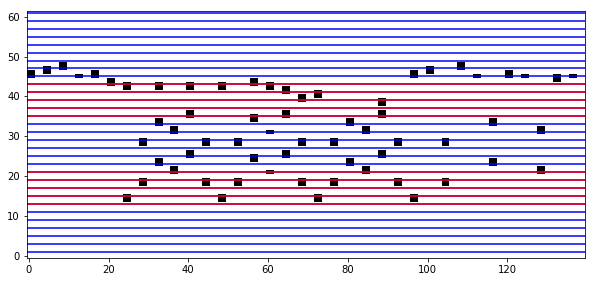

In [12]:
note_events, _ = getNoteEvents(midifile)
bscore, times, num_notes, stafflines, _, _ = generateBootlegScore(note_events, 2, 2)
visualizeBootlegScore(bscore[:,0:140], stafflines)

### Process midi files

In [13]:
def processMidiFile(midifile, outfile):
    
    ### system parameters ###
    timeQuantFactor = 10
    bootlegRepeatNotes = 2
    bootlegFiller = 1
    #########################
    
    print("Processing {}".format(midifile))
    note_events, _ = getNoteEvents(midifile, timeQuantFactor)
    bscore, times, num_notes, stafflines, _, _ = generateBootlegScore(note_events, bootlegRepeatNotes, bootlegFiller)
    
    # save to file
    d = {'bscore': bscore, 'times': times, 'num_notes': num_notes, 'stafflines': stafflines, 'note_events': note_events}
    with open(outfile, 'wb') as f:
        pickle.dump(d, f)

In [14]:
def processAllMidiFiles(filelist, outdir):
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    with open(filelist, 'r') as f:
        for curfile in f:
            curfile = curfile.rstrip()
            basename = os.path.splitext(os.path.basename(curfile))[0]
            outfile = "{}/{}.pkl".format(outdir, basename)
            processMidiFile(curfile, outfile)

In [15]:
filelist = 'cfg_files/midi.test.list' # list of all midi files to process
basedir = 'experiments/exp2'
outdir = '{}/db'.format(basedir) # where to save bootleg scores
processAllMidiFiles(filelist, outdir)

Processing data/midi/p2.mid
Processing data/midi/p3.mid
Processing data/midi/p4.mid
Processing data/midi/p5.mid
Processing data/midi/p6.mid
Processing data/midi/p7.mid
Processing data/midi/p8.mid
Processing data/midi/p9.mid
Processing data/midi/p10.mid
Processing data/midi/p12.mid
Processing data/midi/p13.mid
Processing data/midi/p14.mid
Processing data/midi/p15.mid
Processing data/midi/p16.mid
Processing data/midi/p17.mid
Processing data/midi/p18.mid
Processing data/midi/p19.mid
Processing data/midi/p20.mid
Processing data/midi/p22.mid
Processing data/midi/p23.mid
Processing data/midi/p24.mid
Processing data/midi/p25.mid
Processing data/midi/p26.mid
Processing data/midi/p27.mid
Processing data/midi/p28.mid
Processing data/midi/p29.mid
Processing data/midi/p30.mid
Processing data/midi/p32.mid
Processing data/midi/p33.mid
Processing data/midi/p34.mid
Processing data/midi/p35.mid
Processing data/midi/p36.mid
Processing data/midi/p37.mid
Processing data/midi/p38.mid
Processing data/midi/p